In [146]:
import os
import sys

home_dir = os.getcwd()
sys.path.insert(0, home_dir)

In [147]:
import matplotlib

INTERACTIVE_GRAPH = False
if INTERACTIVE_GRAPH: 
    matplotlib.use('TkAgg')  # or 'Qt5Agg'
else:
    %matplotlib inline

In [ ]:
import traceback
import networkx as nx
import matplotlib.pyplot as plt

from neo4j import GraphDatabase
from matplotlib.lines import Line2D
from rdflib import Graph, Namespace
from netgraph import InteractiveGraph
from typing import Union, Dict, Tuple, List


output_dir = os.path.join(home_dir, "assets")
try:
    os.makedirs(output_dir, exist_ok=True)
except Exception:
    traceback.print_exc(file=sys.stdout)

In [149]:
def generate_knowledge_graph(graph_base: Dict[str, List[str]], graph_structure: Dict[str, Tuple[str, str]]) -> nx.DiGraph:
    graph = nx.DiGraph()
    for domain, fields in graph_base.items():
        for field in fields:
            graph.add_node(field, type=domain)
    for source_vertex, value in graph_structure.items():
        for target_vertex, relationship in value:
            graph.add_edge(source_vertex, target_vertex, relationship=relationship)
    return graph

def add_vertices(graph: nx.DiGraph, new_vertices: Union[Dict[str, str], Tuple[List[str], List[str]]]) -> nx.DiGraph:
    if isinstance(new_vertices, dict):
        for key, value in new_vertices.items():
            graph.add_node(key, type=value)
    else:
        vertices_names, vertices_types = new_vertices
        assert len(vertices_names) == len(vertices_types)
        for vertex_name, vertex_type in zip(vertices_names, vertices_types):
            graph.add_node(vertex_name, type=vertex_type)
    return graph


def add_edges(graph: nx.DiGraph, edges: List[Tuple[str, str, str]]) -> nx.DiGraph:
    for edge in edges:
        source_vertex, target_vertex, relationship = edge
        graph.add_edge(source_vertex, target_vertex, relationship=relationship)
    return graph

In [150]:
knowledge_domains = {
    "Computer Science and Engineering": [
        "Artificial Intelligence", 
        "Machine Learning",
        "Computer Vision",
        "Natural Language Processing",
        "Audio Analysis and Processing",
        "Deep Learning",
        "Reinforcement Learning",
        "Multimodal Learning",
        "Graph Machine Learning",
        "Meta-Learning",
        "Adversarial Attacks"
    ],
    "Mathematics": [
        "Linear Algebra",
        "Probability and Statistics",
        "Calculus",
        "Optimization",
        "Operations Research"
    ],
    "Biology": [
        "Molecular Biology",
        "Cellular Biology",
        "Developmental Biology",
        "Genetics",
        "Epigenetics",
    ],
    "Psychology": [
        "Biopsychology",
        "Clinical Psychology",
        "Cognitive Psychology",
        "Neuropsychology",
        "Behavioral Genetics"
    ],
    "Chemistry": [
        "Biochemistry",
        "Neurochemistry",
        "Organic Chemistry"
    ],
    "Multidisciplinary": [
        "Neuroscience",
        "Biochemistry",
        "Neurophysics",
        "Neurochemistry",
        "Medicine",
        "Cognitive Science"
    ]
}

knowledge_relationships = {
    "Artificial Intelligence": [
        ("Machine Learning", "subfield-of"),
        ("Computer Vision", "subfield-of"),
        ("Natural Language Processing", "subfield-of"),
        ("Audio Analysis and Processing", "subfield-of"),
        ("Linear Algebra", "integrates"),
        ("Calculus", "integrates"),
        ("Optimization", "integrates"),
        ("Probability and Statistics", "integrates"),
        ("Operations Research", "integrates")
    ],
    "Machine Learning": [
        ("Deep Learning", "subfield-of"),
        ("Reinforcement Learning", "subfield-of"),
        ("Multimodal Learning", "subfield-of"),
        ("Graph Machine Learning", "subfield-of"),
        ("Meta-Learning", "subfield-of"),
        ("Adversarial Attacks", "subfield-of")
    ],
    "Multimodal Learning": [
        ("Computer Vision", "integrates"),
        ("Natural Language Processing", "integrates"),
        ("Audio Analysis and Processing", "integrates")
    ],
    "Organic Chemistry": [
        ("Biochemistry", "related-field"),
        ("Molecular Biology", "related-field"),
        ("Cellular Biology", "related-field")
    ],
    "Neurochemistry": [
        ("Biochemistry", "integrates"),
        ("Molecular Biology", "integrates")
    ],
    "Genetics": [
        ("Epigenetics", "subfield-of"),
        ("Behavioral Genetics", "related-field")
    ],
    "Neuroscience": [
        ("Biopsychology", "integrates"),
        ("Clinical Psychology", "integrates"),
        ("Cognitive Psychology", "integrates"),
        ("Neuropsychology", "integrates"),
        ("Behavioral Genetics", "integrates"),
        ("Developmental Biology", "integrates"),
        ("Neurophysics", "integrates"),
        ("Neurochemistry", "integrates"),
        ("Medicine", "integrates"),
        ("Probability and Statistics", "integrates"),
        ("Genetics", "integrates")
    ],
    "Cognitive Science": [
        ("Artificial Intelligence", "integrates"),
        ("Neuroscience", "integrates")
    ]
}

In [151]:
class Neo4jConnection:
    def __init__(self, uri: str, user: str, password: str):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        self.driver.close()

    def get_graph(self) -> nx.MultiDiGraph:
        kg = nx.MultiDiGraph()
        with self.driver.session() as session:
            nodes_query = "MATCH (n) RETURN n.label AS label"
            nodes = session.run(nodes_query)
            for node in nodes:
                label = node["label"]
                if label:  # Ensure label is not None
                    kg.add_node(label)

            edges_query = "MATCH (n)-[r]->(m) RETURN n.label AS source, m.label AS target, type(r) AS relationship"
            edges = session.run(edges_query)
            for edge in edges:
                source = edge["source"]
                target = edge["target"]
                rel = edge["relationship"]
                if source and target and rel:  # Ensure valid data
                    kg.add_edge(source, target, relationship=rel)
        return kg


# RDF handling (optional)
def load_rdf_graph(rdf_file: str) -> dict:
    g = Graph()
    g.parse(rdf_file, format="turtle")
    domains = dict.fromkeys(knowledge_domains.keys(), [])
    for s, p, o in g:
        if str(p).endswith("isSubfieldOf"):
            domain = str(o).split("/")[-1]
            subfield = str(s).split("/")[-1]
            if domain in domains:
                domains[domain].append(subfield)
    return domains


# Load graph from Neo4j (update credentials)
try:
    neo4j_conn = Neo4jConnection(uri="bolt://localhost:7687", user="neo4j", password="your_password")
    kg = neo4j_conn.get_graph()
    neo4j_conn.close()
except Exception as e:
    print(f"Neo4j connection failed: {e}")
    # Fallback graph
    kg = generate_knowledge_graph(knowledge_domains, knowledge_relationships)

Neo4j connection failed: Couldn't connect to localhost:7687 (resolved to ('127.0.0.1:7687',)):
Failed to establish connection to ResolvedIPv4Address(('127.0.0.1', 7687)) (reason [Errno 111] Connection refused)


Graph saved to /home/pkhunter/Repositories/github-pages/docs/knowledge_graph.png


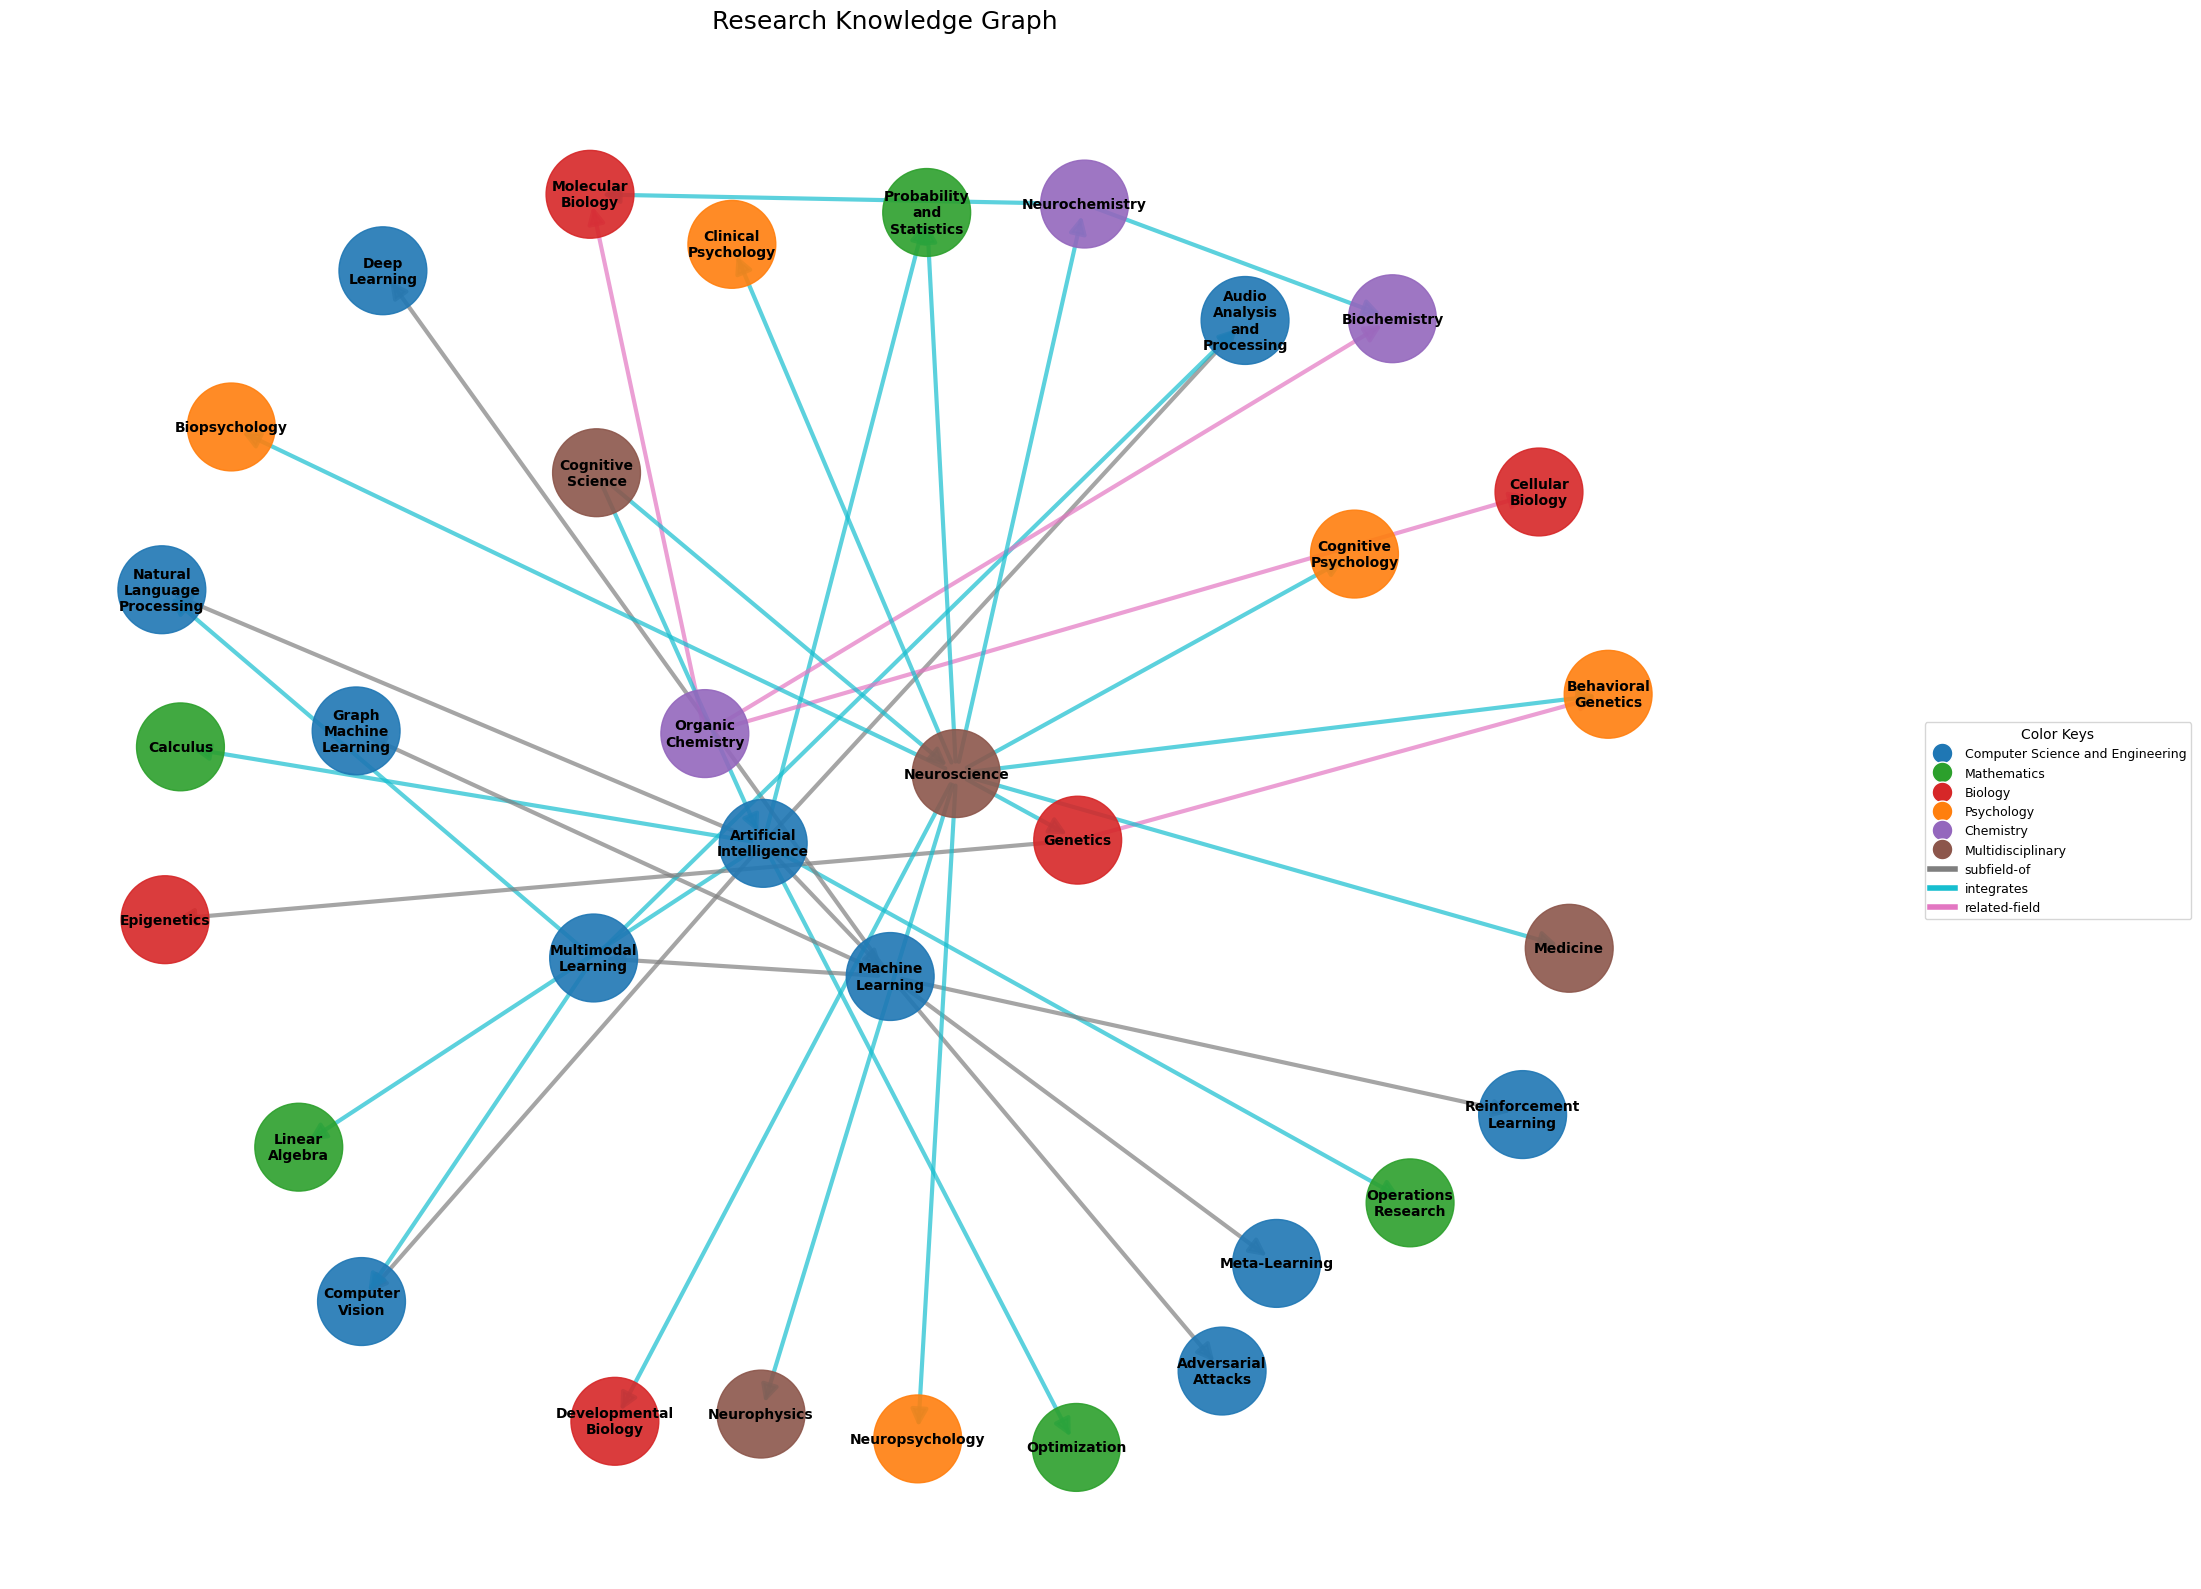

In [ ]:
# Domain colors (vertices)
domain_colors = {
    "Computer Science and Engineering": "#1f77b4",
    "Mathematics": "#2ca02c",
    "Biology": "#d62728",
    "Psychology": "#ff7f0e",
    "Chemistry": "#9467bd",
    "Multidisciplinary": "#8c564b"
}

# Relationship colors (edges)
relationship_colors = {
    "subfield-of": "#7f7f7f",
    "integrates": "#17becf",
    "related-field": "#e377c2"
}

# Create multi-line labels with centered text
labels = {vertex: "\n".join(vertex.split()) for vertex in kg.nodes()}

# Assign colors
vertex_colors = {} if INTERACTIVE_GRAPH else []
for vertex in kg.nodes():
    color_assigned = False
    for domain, fields in knowledge_domains.items():
        if vertex == domain or vertex in fields:
            if INTERACTIVE_GRAPH:
                vertex_colors[vertex] = domain_colors[domain]
            else:
                vertex_colors.append(domain_colors[domain])
            color_assigned = True
            break
    if not color_assigned: # default
        if INTERACTIVE_GRAPH:
            vertex_colors[vertex] = "#bcbd22"
        else:
            vertex_colors.append("#bcbd22")

if INTERACTIVE_GRAPH:
    edge_colors = {}
    for u, v, d in kg.edges(data=True):
        edge_colors[(u, v)] = relationship_colors.get(d.get("relationship", "unknown"), "#000000")
else:
    edge_colors = [relationship_colors[d["relationship"]] for _, _, d in kg.edges(data=True)]

# Visualize graph
plt.figure(figsize=(22, 16))
pos = nx.spring_layout(kg, k=1.2, seed=42)  # Increased k for more spacing

if INTERACTIVE_GRAPH:
        plot_instance = InteractiveGraph(
        kg,
        node_size=5,  # Adjusted for visibility
        node_color=vertex_colors,
        node_labels=labels,
        node_label_offset=0.05,
        node_label_fontdict=dict(size=10, fontweight='bold'),
        edge_color=edge_colors,
        edge_width=3,
        arrows=True,
    )
else:
    nx.draw_networkx_nodes(kg, pos, node_color=vertex_colors, node_size=4000, alpha=0.9)
    nx.draw_networkx_edges(kg, pos, edge_color=edge_colors, width=3, alpha=0.7, arrowsize=25)

    # Draw centered multi-line labels for vertices
    for vertex, (x, y) in pos.items():
        plt.text(x, y, labels[vertex],
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=10,
                fontweight='bold',
                linespacing=1.2)

# Legends (with multi-line labels)
domain_legend = [Line2D([0], [0], marker='o', color='w', label=domain,
                markerfacecolor=color, markersize=15) 
               for domain, color in domain_colors.items()]

relationship_legend = [Line2D([0], [0], color=color, lw=4, label=rel)
                      for rel, color in relationship_colors.items()]

plt.legend(handles=domain_legend + relationship_legend,
          loc='center right',
          fontsize=9,
          title="Color Keys",
          title_fontsize=10,
          bbox_to_anchor=(1.25, 0.5))

plt.title("Research Knowledge Graph", fontsize=18, pad=25)
plt.axis('off')
plt.tight_layout()

# Save the graph
output_path = os.path.join(output_dir, "images", "knowledge_graph.png")
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"Graph saved to {output_path}")
if INTERACTIVE_GRAPH: plt.show()

In [115]:
degree_centrality = nx.degree_centrality(kg)
betweenness_centrality = nx.betweenness_centrality(kg)

print("Most central nodes by degree:")
for node, value in sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True):
    if value > 0.: print(f"- {node}: {value}")

print("\nMost central nodes by betweenness:")
for node, value in sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True):
    if value > 0.: print(f"- {node}: {value}")

Most central nodes by degree:
- Neuroscience: 0.375
- Artificial Intelligence: 0.3125
- Machine Learning: 0.21875
- Multimodal Learning: 0.125
- Genetics: 0.09375
- Neurochemistry: 0.09375
- Organic Chemistry: 0.09375
- Computer Vision: 0.0625
- Natural Language Processing: 0.0625
- Audio Analysis and Processing: 0.0625
- Probability and Statistics: 0.0625
- Molecular Biology: 0.0625
- Behavioral Genetics: 0.0625
- Biochemistry: 0.0625
- Cognitive Science: 0.0625
- Deep Learning: 0.03125
- Reinforcement Learning: 0.03125
- Graph Machine Learning: 0.03125
- Meta-Learning: 0.03125
- Adversarial Attacks: 0.03125
- Linear Algebra: 0.03125
- Calculus: 0.03125
- Optimization: 0.03125
- Operations Research: 0.03125
- Cellular Biology: 0.03125
- Developmental Biology: 0.03125
- Epigenetics: 0.03125
- Biopsychology: 0.03125
- Clinical Psychology: 0.03125
- Cognitive Psychology: 0.03125
- Neuropsychology: 0.03125
- Neurophysics: 0.03125
- Medicine: 0.03125

Most central nodes by betweenness:
- A

In [7]:
# Export to GEXF for Gephi visualization
nx.write_gexf(kg, os.path.join(output_dir, "research_knowledge_graph.gexf"))

# Export to RDF for semantic web applications
rdf_graph = Graph()
ns = Namespace("http://example.org/research/")

for node in kg.nodes:
    rdf_graph.add((ns[node], ns.type, ns[kg.nodes[node]["type"]]))

for u, v, data in kg.edges(data=True):
    rdf_graph.add((ns[u], ns[data["relationship"]], ns[v]))

rdf_graph.serialize(os.path.join(output_dir, "research_knowledge_graph.ttl"), format="turtle")

http://example.org/research/Artificial Intelligence does not look like a valid URI, trying to serialize this will break.
http://example.org/research/Computer Science and Engineering does not look like a valid URI, trying to serialize this will break.
http://example.org/research/Machine Learning does not look like a valid URI, trying to serialize this will break.
http://example.org/research/Computer Science and Engineering does not look like a valid URI, trying to serialize this will break.
http://example.org/research/Computer Vision does not look like a valid URI, trying to serialize this will break.
http://example.org/research/Computer Science and Engineering does not look like a valid URI, trying to serialize this will break.
http://example.org/research/Natural Language Processing does not look like a valid URI, trying to serialize this will break.
http://example.org/research/Computer Science and Engineering does not look like a valid URI, trying to serialize this will break.
http://

Exception: "http://example.org/research/Cognitive Science" does not look like a valid URI, I cannot serialize this as N3/Turtle. Perhaps you wanted to urlencode it?

In [6]:
driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "password"))

def add_relation(tx, source, relation, target):
    tx.run("MERGE (a:Entity {name: $source}) "
          "MERGE (b:Entity {name: $target}) "
          "MERGE (a)-[r:RELATION {type: $relation}]->(b)",
          source=source, target=target, relation=relation)

with driver.session() as session:
    session.execute_write(add_relation, "Apple", "founded_by", "Steve Jobs")

/tmp/ipykernel_14744/2017093661.py:10: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(add_relation, "Apple", "founded_by", "Steve Jobs")
Transaction failed and will be retried in 1.0544976021853103s (Couldn't connect to localhost:7687 (resolved to ('127.0.0.1:7687',)):
Failed to establish connection to ResolvedIPv4Address(('127.0.0.1', 7687)) (reason [Errno 111] Connection refused))
Transaction failed and will be retried in 1.6660611145779454s (Couldn't connect to localhost:7687 (resolved to ('127.0.0.1:7687',)):
Failed to establish connection to ResolvedIPv4Address(('127.0.0.1', 7687)) (reason [Errno 111] Connection refused))
Transaction failed and will be retried in 3.387281482070035s (Couldn't connect to localhost:7687 (resolved to ('127.0.0.1:7687',)):
Failed to establish connection to ResolvedIPv4Address(('127.0.0.1', 7687)) (reason [Errno 111] Connection refused))
Transaction failed and will be retried in 6.431048904560047s (Co

KeyboardInterrupt: 